# Italy in Magazines

My project is based on extensive use of web scraping and partial integrations from ACNP, Wikidata and DBpedia.

The main source of my studies has been CIRCE, the database of the University of Trento, developed since 1998 by the Department of Philological and Historical Sciences of the University of Trento. The project CIRCE focused on addressing the issues of preservation and consultation of Italian literary journals, which are a key element for studying cultural movements. It is well known that, starting from the Enlightenment, periodical publications have played a decisive role in the development of European culture, giving rise to a phenomenon that has reached such proportions and importance that the 20th century has been called the "century of magazines".

I have made it a priority to handle the database with the ethics it deserves, and I contacted Professor [Carla Gubert](https://webapps.unitn.it/du/it/Persona/PER0003419/Curriculum) for clarification on the possibility of using the data. The professor—whom I thank again for her prompt response—did not send me the files directly, but granted me permission to reuse the online material.

The online material is rich and intricately nested and data extraction was certainly one of the most interesting challenges, but the results supported my research questions.

The research questions involved integration with web scraping from the ACNP website (the Italian catalog of periodicals) and API queries to Wikidata and DBpedia. While the searches on ACNP were satisfactory, unfortunately, not all my API queries found matches in the Wiki family databases—but I will discuss percentages later.

In the following paragraphs, I will introduce my research questions and the strategies I employed.

## Introduction

If the 20th century is that of magazines, what can Italian magazines tell us about the intense and problematic history of the last century?

>"[...] an era of violent acceleration of modernity, of tumultuous development of industry and technology, of unprecedented conflicts and massacres, marked by the two world wars [...]. The acceleration toward modernity and toward a mass society, the development of capitalism, the imperialist expansion of great states, phenomena that in the previous era had taken on an impetuous and irresistible momentum, leading to the belief in the possibility of happy and unlimited progress, thus found an irrational and disastrous outcome."
—Giulio Ferroni, _Storia della letteratura italiana: Il Novecento e il nuovo millennio_, 2017, p.3

And above all, what do they tell us about the cultural reality of the peninsula? The moment of growth preceding the war, where the most enthusiastic and total modernization intertwines with the enduring centuries-old backwardness of the South? The social conflict and fragility of liberal institutions that culminated in the fascist dictatorship?

What do they tell us about the post-war period, the radical social transformations, and the new openness towards contemporary European culture?

With the theoretical support of G. Ferroni's _Storia della letteratura italiana_, I questioned the data, seeking answers to some specific research questions: questions that do not aim to exhaust such a problematic and elusive century but hope to add complexity and new points of reference.

## RQ: What are the most important cultural centers in the twentieth century?


To answer this question, I focused on collecting Italian magazines from the CIRCE website. The website features a ["Magazines" section ](https://r.unitn.it/it/lett/circe/riviste) with a clickable list of magazines accessible to the public, most of which (though not all) have specific entries that link to the ACNP record of the respective magazine.

In order, I collected all the magazine titles, publication information, and the link to the ACNP page. The link then allowed me to access resources, discover the magazine's place of publication, and integrate the data.


#### Data scraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import json


base_url = 'https://r.unitn.it'
start_url = 'https://r.unitn.it/it/lett/circe/riviste'


headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}


response = requests.get(start_url, headers=headers)


data_list = []

acnp_data_list = []


def estrai_dati_acnp(acnp_url):
    acnp_response = requests.get(acnp_url, headers=headers)
    if acnp_response.status_code == 200:
        acnp_soup = BeautifulSoup(acnp_response.content, 'html.parser')

        
        titolo = acnp_soup.find('h1').get_text(strip=True) if acnp_soup.find('h1') else "Titolo non disponibile"

        
        acnp_descrittori = {'titolo': titolo, 'url': acnp_url}

        
        rows = acnp_soup.find_all('div', class_='row')

        for row in rows:
            label = row.find('div', class_='profile-label')
            content = row.find('div', class_='profile-content')
            if label and content:
                key = label.get_text(strip=True).replace(':', '')
                value = content.get_text(strip=True)
                acnp_descrittori[key] = value

        return acnp_descrittori
    else:
        print(f"Errore nella richiesta alla pagina ACNP: {acnp_response.status_code}")
        return None


if response.status_code == 200:
    
    soup = BeautifulSoup(response.content, 'html.parser')

    
    links = soup.find_all('a')

    
    node_links = []
    for link in links:
        href = link.get('href')
        if href and '/node/' in href:
            full_url = base_url + href
            node_links.append(full_url)

    
    for node_link in node_links:
        page_response = requests.get(node_link, headers=headers)
        if page_response.status_code == 200:
            page_soup = BeautifulSoup(page_response.content, 'html.parser')

            
            title_div = page_soup.find('div', class_='field-item even')
            if title_div:
                
                title_text = title_div.get_text(strip=True)

                
                descrittori_div = page_soup.find('div', class_='field field-name-body field-type-text-with-summary field-label-hidden')
                descrittori = {}

                if descrittori_div:
                    strong_tags = descrittori_div.find_all('strong')
                    for strong in strong_tags:
                        
                        key = strong.get_text(strip=True).replace(':', '')

                        
                        value = strong.next_sibling

                        
                        if value and isinstance(value, str):
                            descrittori[key] = value.strip()
                        else:
                            
                            next_element = strong.find_next_sibling(text=True)
                            if next_element:
                                descrittori[key] = next_element.strip()

                    
                    links = descrittori_div.find_all('a')
                    for link in links:
                        href = link.get('href')
                        if href:
                            descrittori[link.get_text(strip=True)] = href

                
                if "scheda catalografica in ACNP" in descrittori:
                    acnp_url = descrittori["scheda catalografica in ACNP"]
                    acnp_data = estrai_dati_acnp(acnp_url)
                    if acnp_data:
                        acnp_data_list.append(acnp_data)

                
                data_list.append({
                    'url': node_link,
                    'titolo': title_text,
                    'descrittori': descrittori
                })

    
    with open('riviste_data.json', 'w', encoding='utf-8') as json_file:
        json.dump(data_list, json_file, ensure_ascii=False, indent=4)

    
    with open('acnp_data.json', 'w', encoding='utf-8') as json_file:
        json.dump(acnp_data_list, json_file, ensure_ascii=False, indent=4)

    print("Dati estratti e salvati nei file 'riviste_data.json' e 'acnp_data.json'.")
else:
    print(f"Errore nella richiesta HTTP: {response.status_code}")


#### Data cleaning

In [ ]:
import re
import json


with open('/content/acnp_data.json', 'r') as jsonfile:
    data = json.load(jsonfile)


def clean_place_publisher(place_publisher):
    
    place_publisher = re.sub(r'\[.*?\]', '', place_publisher)
    
    match = re.match(r'^\s*([^\n:]+)', place_publisher)
    if match:
        return match.group(1).strip()
    return place_publisher.strip()


for record in data:
    place_publisher = record.get("Place  Publisher", "")
    cleaned_place = clean_place_publisher(place_publisher)
    record["Place  Publisher"] = cleaned_place


with open('/content/cleaned_acnp_data.json', 'w') as jsonfile:
    json.dump(data, jsonfile, indent=4)

print("Il file è stato pulito e salvato come 'cleaned_acnp_data.json'.")


#### Join data

In [ ]:
import json


with open('/content/riviste_data.json', 'r') as jsonfile1:
    first_data = json.load(jsonfile1)

with open('/content/cleaned_acnp_data.json', 'r') as jsonfile2:
    second_data = json.load(jsonfile2)


second_data_dict = {entry["url"]: entry for entry in second_data}


for record in first_data:
    acnp_url = record.get("descrittori", {}).get("scheda catalografica in ACNP")
    if acnp_url and acnp_url in second_data_dict:
        place_publisher = second_data_dict[acnp_url].get("Place  Publisher")
        if place_publisher:
            record["descrittori"]["Place Publisher"] = place_publisher


with open('/content/updated_first_file.json', 'w') as jsonfile:
    json.dump(first_data, jsonfile, indent=4)

print("Il file è stato aggiornato e salvato come 'updated_first_file.json'.")


#### Spatial exploration of data

In [ ]:

fig, ax = plt.subplots(figsize=(10, 10))  


world.plot(ax=ax, color='lightgray')


gdf.plot(ax=ax, marker='o', color='red', markersize=5)


ax.set_xlim([-5.0, 25.0])
ax.set_ylim([35.0, 50.0]) 


for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Place Publisher']):
    ax.text(x, y, label, fontsize=8)

plt.title('Geographic Distribution of Journals in Italy')
plt.show()


#### Temporal exploration of data

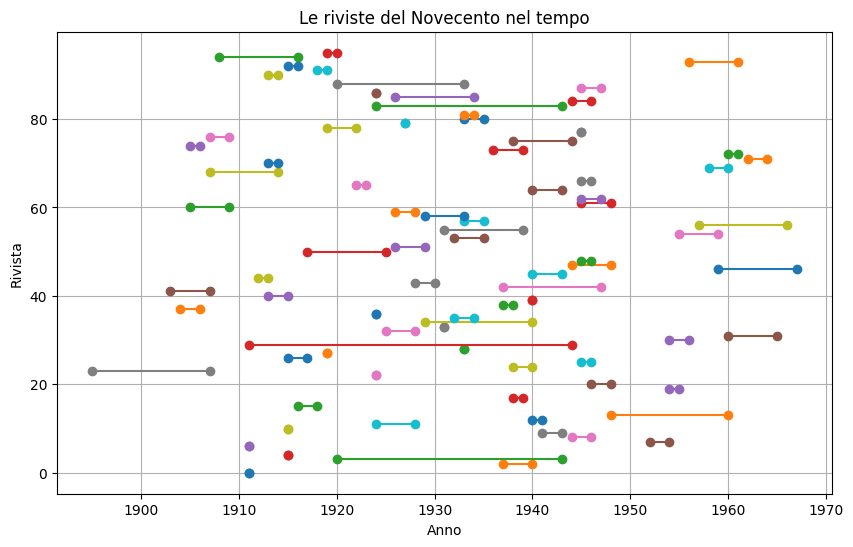

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re


def extract_year(anno_str):
    anno_str = re.sub(r'\D', '', anno_str)  
    try:
        return int(anno_str) if anno_str else 0
    except ValueError:
        return 0


with open('/Users/Mosca/Desktop/ulimo_joined.json') as f:
    journals = json.load(f)


data = []
for journal in journals:
    titolo = journal['titolo']
    anno_primo_str = journal['descrittori'].get('Anno primo', '0')
    anno_ultimo_str = journal['descrittori'].get('Anno ultimo', '0')

    
    anno_primo = extract_year(anno_primo_str)
    anno_ultimo = extract_year(anno_ultimo_str)

    if anno_primo > 0 and anno_ultimo > 0:
        data.append([titolo, anno_primo, anno_ultimo])


df = pd.DataFrame(data, columns=['Titolo', 'Anno Primo', 'Anno Ultimo'])


df_filtered = df[df['Anno Ultimo'] <= 1970]


plt.figure(figsize=(10, 6))
for i, row in df_filtered.iterrows():
    plt.plot([row['Anno Primo'], row['Anno Ultimo']], [i, i], marker='o')

plt.xlabel('Anno')
plt.ylabel('Rivista')
plt.title('Le riviste del Novecento nel tempo')
plt.grid(True)
plt.show()


## (Side RQ): Is fascist censorship visible in the database?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df_0 = pd.read_json('/Users/Mosca/Desktop/Information visualisation/autori_dati.json')
df_1 = pd.read_json('/Users/Mosca/Desktop/Information visualisation/autori_dati1.json')
df_2 = pd.read_json('/Users/Mosca/Desktop/Information visualisation/autori_dati2.json')


merged_df = pd.concat([df_0, df_1, df_2], ignore_index=True)


dati_riformattati = []


for index, row in merged_df.iterrows():
    author = row['author']
    for article in row['articles']:
        articolo_info = {
            'author': author,
            'rivista': article.get('rivista', ''),
            'anno': article.get('anno', ''),
            'titolo': article.get('titolo', ''),
            'tipologia': article.get('tipologia', ''),
            'parola chiave': article.get('parola chiave', '')
        }
        dati_riformattati.append(articolo_info)

df_riformattato = pd.DataFrame(dati_riformattati)
df_riformattato.to_csv('/Users/Mosca/Desktop/Information visualisation/articoli_completi.json')

In [ ]:

df_riformattato = pd.DataFrame(dati_riformattati)

In [ ]:

lista_chiavi = df_riformattato['parola chiave'].drop_duplicates()


lista_chiavi = lista_chiavi[~lista_chiavi.str.contains('letter|scritt|art|cinem|poe|liric|teatr', case=False, na=False)]


lista_chiavi = lista_chiavi[~lista_chiavi.str.contains(',|«', na=False)]


lista_chiavi


0                        Scuola
1                              
3                      Editoria
12             Pittura italiana
13         Biblioteche italiane
                  ...          
44866    Terminologia giuridica
44906                  Lussuria
44931              Stadio Berta
45050                Ginnastica
45112                  Acustica
Name: parola chiave, Length: 2133, dtype: object

In [ ]:
from bertopic import BERTopic


topic_model = BERTopic(min_topic_size=20, language="italian")


topics, probabilities = topic_model.fit_transform(lista_chiavi.values)


In [ ]:
topics, probabilities = topic_model.fit_transform(lista_chiavi['parola chiave'].values)


lista_chiavi['Cluster'] = topics


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_riformattato =pd.read_csv('/content/file_autori_rivista_aggiornato.csv')
lista_chiavi = pd.read_csv('/content/c_filtrati.csv')

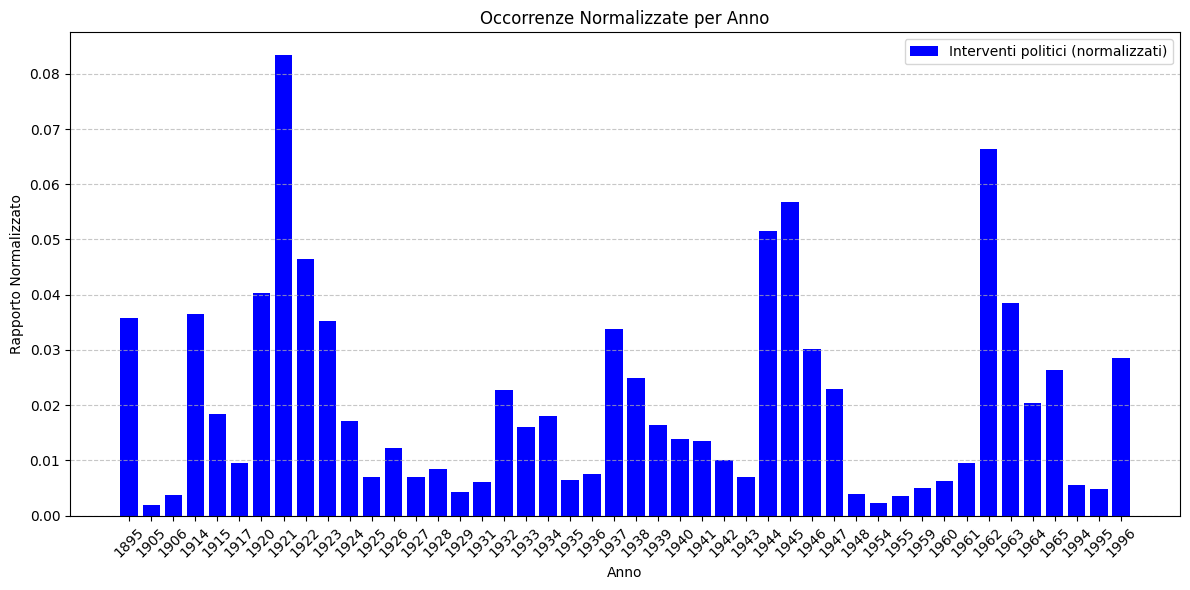

In [4]:
import pandas as pd
import matplotlib.pyplot as plt



file_totale_path = r'C:\Users\Mosca\Desktop\Information visualisation\file_autori_rivista_aggiornato.csv'  
df_totale = df_riformattato

total_counts = df_totale['anno'].value_counts().reset_index()
total_counts.columns = ['anno', 'totale_articoli']


matched_rows = df_riformattato[df_riformattato['parola chiave'].isin(lista_chiavi['Parola Chiave'])]

if matched_rows.empty:
    print("Nessuna corrispondenza trovata.")
else:
    
    matched_rows = matched_rows.merge(lista_chiavi[['Parola Chiave', 'Cluster']],
                                        left_on='parola chiave',
                                        right_on='Parola Chiave',
                                        how='left')

    
    year_counts = matched_rows['anno'].value_counts().reset_index()
    year_counts.columns = ['anno', 'conteggio']

    
    year_counts['anno'] = pd.to_numeric(year_counts['anno'], errors='coerce')
    year_counts = year_counts.dropna()  
    year_counts = year_counts.sort_values(by='anno')  

    
    df_year_counts = year_counts.merge(total_counts, on='anno', how='left')

    
    df_year_counts['rapporto_normalizzato'] = df_year_counts['conteggio'] / df_year_counts['totale_articoli']

    
    plt.figure(figsize=(12, 6))
    plt.bar(df_year_counts['anno'].astype(str), df_year_counts['rapporto_normalizzato'], color='blue', label='Interventi politici (normalizzati)')

    plt.title('Occorrenze Normalizzate per Anno')
    plt.xlabel('Anno')
    plt.ylabel('Rapporto Normalizzato')
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    
    plt.tight_layout()
    plt.show()

## RQ:What is the relationship between Italian and foreign authors in the last century?

This data collection was the longest , but I used it as the basis for this and the next research question. I created a web scraping code from the three CIRCE databases.

> - Magazines of the 20th Century: This concerns the most important publications that have marked the cultural and literary history of the 20th century, starting with «Convito» by Adolfo De Bosis, first published in 1895 and concluded in 1905, up to the more recent magazines of the 1960s and 1970s.
>- Futurist Magazines: This concerns the most important and valuable magazines born within the Futurist movement, mostly preserved in original copies at the MART Library (Museum of Modern and Contemporary Art of Trento and Rovereto).
>- Magazines and Translations: This collects translations from foreign literatures that appeared in the most relevant literary publications and almanacs of the 20th century.
From these databases, I gathered information related to authors, titles, and the year of the articles. I also collected data related to the publication magazine, the type, and the theme of the publication.

These data were then combined with data from DBpedia and Wikidata through SPARQL queries. The queries mainly served to trace the biographical information of the authors.

### Data scraping

Il seguente script è stato utilizzato tre volte con diversi url per esaurire tutte e tre le banche dati.

In [ ]:
import time
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys


visited_pages = []
chrome_options = Options()
chrome_options.add_argument('--headless')  
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-extensions')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--blink-settings=imagesEnabled=false')  

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)


url = "http://circe.lett.unitn.it/ZwebSvr/Zetesis.ASP?WCI=Browse&WCE=BROWSE&WCU=AUTORE"


authors_seen = set()  
articles_seen = set()  


def extract_authors_from_table(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    tables = soup.find_all('table')

    if len(tables) >= 3:
        table = tables[2]
        tbody = table.find('tbody')
        rows = tbody.find_all('tr')
        authors = []

        for index, row in enumerate(rows, start=0):  
            tds = row.find_all('td')
            if len(tds) >= 2:
                link = tds[1].find('a')
                if link:
                    author_name = link.text.strip()
                    author_link = link['href']
                    authors.append((index, author_name, author_link))  
        print(authors)
        return authors

    return []


def click_article_and_extract_info(article_index):
    try:
        
        links = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.XPATH, "//a[@name='HTZBLK']"))
        )
        
        links[article_index].click()
        time.sleep(1)

        
        article_info = extract_article_info(driver.page_source)
        driver.back()
        return article_info

    except Exception as e:
        print(f"Errore nel cliccare l'articolo {article_index}: {str(e)}")
        return None

def click_next_if_available():
    try:
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.NAME, "HTZPGD"))
        )
        next_button.send_keys(Keys.ENTER)
        time.sleep(1)  
        return True
    except Exception as e:
        print("Nessun pulsante 'next' trovato nella pagina degli articoli.")
        return False


def extract_articles_from_author_page(index, author_link, author_name):
    articles = []
    try:
        
        links = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.XPATH, "//a[@name='HTZBLK']"))
        )

        
        links[index].click()
        visited_pages.append({'author': author_name, 'url': driver.current_url, 'type': 'author_page'})
    except Exception as e:
        print(f"Errore nel cliccare sull'elemento specificato: {str(e)}")
        return articles

    time.sleep(1)
    times_back= 0
    
    while True:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tables = soup.find_all('table')

        if len(tables) >= 3:
            table = tables[2]
            tbody = table.find('tbody')
            rows = tbody.find_all('tr')

            for article_index, row in enumerate(rows):
                tds = row.find_all('td')
                if len(tds) >= 2:
                    article_link = tds[1].find('a')
                    if article_link:
                        article_title = article_link.text.strip()

                        
                        if article_title not in articles_seen:
                            articles_seen.add(article_title)  

                            
                            article_info = click_article_and_extract_info(article_index)
                            if article_info:
                                articles.append(article_info)
        times_back+=1
        
        if not click_next_if_available():
            break  
    for i in range(times_back):
        driver.back()  
    return articles




def extract_article_info(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    info = {}

    
    font_element = soup.find('font', {'color': "

    if font_element:
        
        outer_table = font_element.find('table')
        if outer_table:
            tbody = outer_table.find('tbody')
            if tbody:
                
                inner_table = tbody.find_all('table')[0]  
                if inner_table:
                    inner_tbody = inner_table.find('tbody')
                    if inner_tbody:
                        
                        rows = inner_tbody.find_all('tr')
                        for row in rows:
                            header = row.find('b')
                            if header:
                                header_text = header.text.strip()
                                if "Rivista:" in header_text:
                                    info['rivista'] = row.find_all('td')[1].text.strip()
                                elif "Anno:" in header_text:
                                    info['anno'] = row.find_all('td')[1].text.strip()
                                elif "Tipologia:" in header_text:
                                    info['tipologia'] = row.find_all('td')[1].text.strip()
                                elif "Titolo:" in header_text:
                                    info['titolo'] = row.find_all('td')[1].text.strip()
                                elif "Parola chiave:" in header_text:
                                    info['parola chiave'] = row.find_all('td')[1].text.strip()


    return info




def save_data_incrementally(author_data):
    with open('autori_dati.json', 'a') as f:
        json.dump(author_data, f, indent=4)
        f.write(",\n")  


def click_next_multiple_times(driver, num_clicks):
    for i in range(num_clicks):
        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.NAME, "HTZPGD"))
            )
            next_button.click()  
            time.sleep(1)  
            print(f"Pagina successiva {i + 1}/{num_clicks} caricata con successo.")
        except Exception as e:
            print(f"Errore nel cliccare sul pulsante 'next' alla pagina {i + 1}: {str(e)}")
            break  


def navigate_and_collect(driver):
    
    click_next_multiple_times(driver, 0)

    all_data = []

    while True:  
        time.sleep(1)

        
        page_source = driver.page_source
        authors = extract_authors_from_table(page_source)

        for index, author_name, author_link in authors:
            if author_name in authors_seen or author_name == "[Anonimo]":
                continue  

            
            authors_seen.add(author_name)
            print(f"Autore consultato: {author_name}")

            
            articles = extract_articles_from_author_page(index, author_link, author_name)

            
            if articles:
                author_data = {
                    'author': author_name,
                    'articles': articles
                }
                all_data.append(author_data)

                
                save_data_incrementally(author_data)

        
        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.NAME, "HTZPGD"))
            )
            next_button.click()  

            
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//a[@name='HTZBLK']"))
            )

        except Exception as e:
            print(f"Errore nel cliccare il pulsante next o fine della lista: {str(e)}")
            break  

    return all_data


driver.get(url)


navigate_and_collect(driver)


driver.quit()

### Work on authors' names

In [ ]:
import json
import pandas as pd
import re  


try:
    with open('/Users/Mosca/Desktop/autori_dati.json', 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
except FileNotFoundError:
    print("Il file JSON non è stato trovato.")
    exit(1)
except json.JSONDecodeError:
    print("Errore nel decodificare il file JSON.")
    exit(1)


autori_list = []


for item in data:
    author = item.get('author', '')

    
    match = re.search(r'\[(.*?)\]', author)
    if match:
        
        author = match.group(1).strip()  
    elif ',' not in author:
        
        continue

    
    if ',' in author:
        cognome, nome = author.split(',', 1)
        cognome = cognome.strip()
        nome = nome.strip()
        
        if cognome and nome:
            autori_list.append({'Cognome': cognome, 'Nome': nome})
    else:
        
        print(f"Formato non riconosciuto per l'autore: {author}")


df = pd.DataFrame(autori_list)


df.to_csv('autori_nomi.csv', index=False, encoding='utf-8')


### Search for authors in Wikidata (and DBpedia)

In [ ]:
import pandas as pd
import requests
from SPARQLWrapper import SPARQLWrapper, JSON
import time


df = pd.read_csv('autori_nomi.csv')


def cerca_dbpedia(nome, cognome):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT ?birthYear ?birthPlace ?person WHERE {{
        ?person rdf:type dbo:Person .
        ?person rdfs:label "{nome} {cognome}"@en .
        OPTIONAL {{ ?person dbo:birthDate ?birthYear . }}
        OPTIONAL {{ ?person dbo:birthPlace ?birthPlace . }}
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    try:
        results = sparql.query().convert()
        if results['results']['bindings']:
            person = results['results']['bindings'][0]
            return {
                "birthYear": person.get('birthYear', {"value": "N/A"}),
                "birthPlace": person.get('birthPlace', {"value": "N/A"}),
                "dbpedia_link": person.get('person', {}).get('value', 'N/A')  
            }
        else:
            return {"birthYear": {"value": "N/A"}, "birthPlace": {"value": "N/A"}, "dbpedia_link": "N/A"}
    except Exception as e:
        print(f"Errore durante la ricerca su DBpedia per {nome} {cognome}: {e}")
        return {"birthYear": {"value": "Errore"}, "birthPlace": {"value": "Errore"}, "dbpedia_link": "Errore"}



def cerca_wikidata(nome, cognome):
    search_url = "https://www.wikidata.org/w/api.php"
    params = {
        'action': 'wbsearchentities',
        'search': f"{nome} {cognome}",
        'language': 'en',
        'format': 'json'
    }

    try:
        response = requests.get(search_url, params=params)
        response.raise_for_status()  
        data = response.json()

        if data['search']:
            
            entity = estrai_primo_politico(data['search'], nome, cognome)

            if entity:
                entity_id = entity['id']

                
                query_url = "https://query.wikidata.org/sparql"
                query = f"""
                SELECT ?birthYear ?birthPlace WHERE {{
                    wd:{entity_id} wdt:P569 ?birthYear .
                    wd:{entity_id} wdt:P19 ?birthPlace .
                }}
                """
                sparql = SPARQLWrapper(query_url)
                sparql.setQuery(query)
                sparql.setReturnFormat(JSON)
                results = sparql.query().convert()

                if results['results']['bindings']:
                    return {
                        "birthYear": results['results']['bindings'][0].get('birthYear', {"value": "N/A"}).get('value', 'N/A'),
                        "birthPlace": results['results']['bindings'][0].get('birthPlace', {"value": "N/A"}).get('value', 'N/A'),
                        "wikidata_link": f"https://www.wikidata.org/wiki/{entity_id}"  
                    }
                else:
                    return {"birthYear": {"value": "N/A"}, "birthPlace": {"value": "N/A"}, "wikidata_link": "N/A"}
            else:
                return {"birthYear": {"value": "N/A"}, "birthPlace": {"value": "N/A"}, "wikidata_link": "N/A"}
        else:
            return {"birthYear": {"value": "N/A"}, "birthPlace": {"value": "N/A"}, "wikidata_link": "N/A"}

    except requests.exceptions.HTTPError as http_err:
        print(f"Errore HTTP durante la ricerca su Wikidata per {nome} {cognome}: {http_err}")
        return {"birthYear": {"value": "Errore"}, "birthPlace": {"value": "Errore"}, "wikidata_link": "Errore"}
    except Exception as e:
        print(f"Errore durante la ricerca su Wikidata per {nome} {cognome}: {e}")
        return {"birthYear": {"value": "Errore"}, "birthPlace": {"value": "Errore"}, "wikidata_link": "Errore"}



words = ["politician", "artist", "politico", "artista", "scrittore", "scrittrice", "giornalista", "critico", "critica", "poeta", "poetessa"]


def estrai_primo_politico(results, nome, cognome):
    
    primo_resultato = None
    nome_completo = f"{nome} {cognome}".lower()

    
    for i, result in enumerate(results[:3]):  
        label = result.get('label', '').lower()
        description = result.get('description', '').lower()

        
        if i == 0 and label == nome_completo:
            primo_resultato = result

        
        if label == nome_completo:
            for w in words:
                if w in description:
                    return result

    
    return primo_resultato if primo_resultato else None



results_dbpedia = []
results_wikidata = []
names = []
surnames = []


for index, row in df.iterrows():

        nome = row['Nome']
        cognome = row['Cognome']

        
        dbpedia_result = cerca_dbpedia(nome, cognome)
        results_dbpedia.append(dbpedia_result)

        
        wikidata_result = cerca_wikidata(nome, cognome)
        results_wikidata.append(wikidata_result)

        
        names.append(nome)
        surnames.append(cognome)

        
        time.sleep(1)  


results_df = pd.DataFrame({
    'Nome': names,
    'Cognome': surnames,
    'DBpedia_Anno_Nascita': [result.get('birthYear', 'N/A') for result in results_dbpedia],
    'DBpedia_Luogo_Nascita': [result.get('birthPlace', 'N/A') for result in results_dbpedia],
    'DBpedia_Link': [result.get('dbpedia_link', 'N/A') for result in results_dbpedia],  
    'Wikidata_Anno_Nascita': [result.get('birthYear', 'N/A') for result in results_wikidata],
    'Wikidata_Luogo_Nascita': [result.get('birthPlace', 'N/A') for result in results_wikidata],
    'Wikidata_Link': [result.get('wikidata_link', 'N/A') for result in results_wikidata]  
})


results_df.to_csv('risultati.csv', index=False)

print("Ricerca completata. Risultati salvati in 'risultati.csv'.")


In [ ]:
import numpy as np
results_df.replace("{'value': 'N/A'}", None, inplace=True)


results_df = results_df.where(pd.notnull(results_df), None)


df_cleaned = results_df[~results_df.iloc[:, 2:].isnull().all(axis=1)]

The following code was helpful for me to evaluate my SPARQL queries: in general, Wikidata contains more information than DBpedia. Therefore, I decided to limit myself to using this resource.

In [ ]:
count_dbpedia = df_cleaned['DBpedia_Link'].notna().sum()  
count_wikidata = df_cleaned['Wikidata_Link'].notna().sum()
print(count_dbpedia, count_wikidata)

In [ ]:
import pandas as pd

def create_filtered_dataframe(df_cleaned):
    
    filtered_df_cleaned = df_cleaned[(df_cleaned['DBpedia_Link'].isna()) & (df_cleaned['Wikidata_Link'].notna())]

    
    result_df_cleaned = filtered_df_cleaned[['Nome', 'Cognome', 'DBpedia_Link', 'Wikidata_Link']]

    return result_df_cleaned

filtered_result = create_filtered_dataframe(df_cleaned)
print(filtered_result)
filtered_result.to_csv('/Users/Mosca/Desktop/db_oppure_wiki.csv', index=False)


In [ ]:
import pandas as pd

def create_dataframes(df):
    
    wikidata_df = df[['Nome', 'Cognome', 'Wikidata_Anno_Nascita', 'Wikidata_Luogo_Nascita', 'Wikidata_Link']].dropna()

    return wikidata_df


wikidata_df = create_dataframes(df_cleaned)



In [ ]:
wikidata_df.to_csv('/Users/Mosca/Desktop/wikida_principale.csv', index=False)

### Search citizenships in Wikidata

In [ ]:
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON


def extract_wikidata_id(wikidata_link):
    return wikidata_link.split('/')[-1]


def sparql_query(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_country_of_citizenship(wikidata_id):
    query = f"""
    SELECT ?citizenshipLabel WHERE {{
      wd:{wikidata_id} wdt:P27 ?citizenship.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    result = sparql_query(query)
    if result["results"]["bindings"]:
        return result["results"]["bindings"][0]["citizenshipLabel"]["value"]
    return None


def get_country_of_birthplace(wikidata_place_id):
    query = f"""
    SELECT ?countryLabel WHERE {{
      wd:{wikidata_place_id} wdt:P17 ?country.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    result = sparql_query(query)
    if result["results"]["bindings"]:
        return result["results"]["bindings"][0]["countryLabel"]["value"]
    return None


def find_citizenship_or_country(df):
    citizenships = []

    for index, row in df.iterrows():
        wikidata_id = extract_wikidata_id(row['Wikidata_Link'])

        
        citizenship = get_country_of_citizenship(wikidata_id)

        
        if citizenship is None and pd.notna(row['Wikidata_Luogo_Nascita']):
            birthplace_id = extract_wikidata_id(row['Wikidata_Luogo_Nascita'])
            citizenship = get_country_of_birthplace(birthplace_id)

        citizenships.append(citizenship if citizenship else "Unknown")

    
    df['Country'] = citizenships
    return df


df = pd.read_csv('/content/wikida_principale.csv')


df_with_country = find_citizenship_or_country(df)


df_with_country.to_csv('/content/file_con_country.csv', index=False)

print(df_with_country)


In [ ]:
import pandas as pd
from collections import Counter

def count_countries(file_path):

    
    df = pd.read_csv(file_path)


    country_counts = Counter(df['Country'])  

    return dict(country_counts)

country_count = count_countries("/content/file_con_country.csv")


print(country_count)

Update file

In [ ]:
import pandas as pd


df_autori = pd.read_csv(r'C:\Users\Mosca\Downloads\file_con_country.csv')  
df_articoli = pd.read_csv(r'C:\Users\Mosca\Desktop\tutti_articoli.csv')  



df_autori['Nome_Completo'] = df_autori['Cognome'] + ', ' + df_autori['Nome']


df_articoli['Nome_Completo'] = df_articoli['author'].apply(lambda x: x.strip())


date_per_autore = df_articoli.groupby('Nome_Completo')['anno'].apply(list).reset_index()


df_risultato = pd.merge(df_autori, date_per_autore, on='Nome_Completo', how='inner')


df_risultato = df_risultato[['Nome', 'Cognome', 'Wikidata_Anno_Nascita', 'Country', 'anno']]




print("Operazione completata, dati salvati in output.csv")

df_risultato.to_csv(r'C:\Users\Mosca\Downloads\autori_esteri.csv', index=False)


Operazione completata, dati salvati in output.csv


### Results visualization

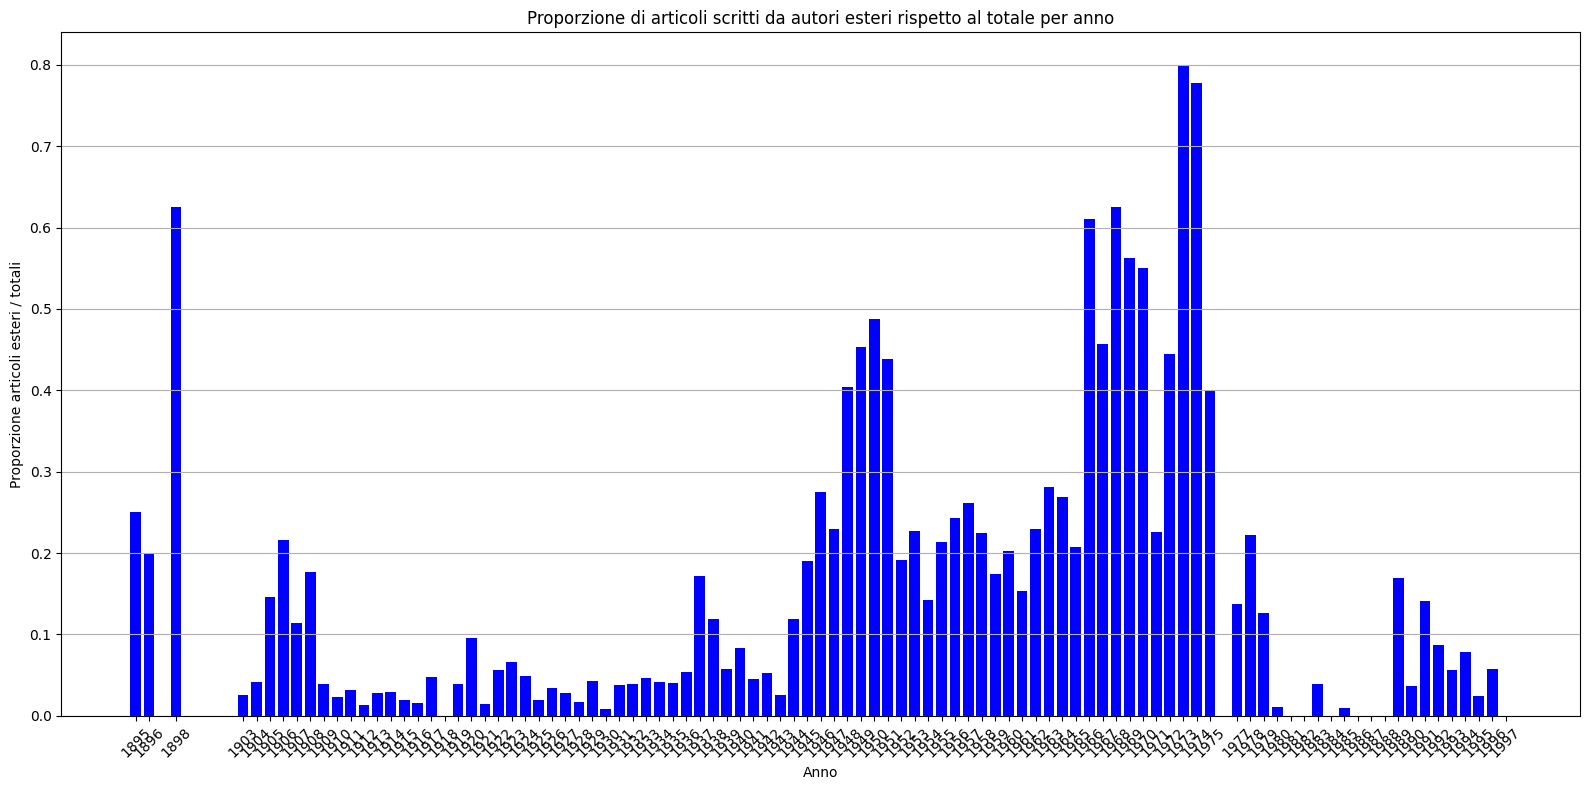

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import json


file_esteri_path = r'C:\Users\Mosca\Downloads\autori_esteri.csv'  
df_esteri = pd.read_csv(file_esteri_path)

file_totale_path = r'C:\Users\Mosca\Desktop\Information visualisation\file_autori_rivista_aggiornato.csv'  
df_totale = pd.read_csv(file_totale_path)


df_esteri = df_esteri[df_esteri['Country'] != 'Italy']


df_esteri['anno'] = df_esteri['anno'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x])


all_years_esteri = [year for sublist in df_esteri['anno'] for year in sublist]


year_counts_esteri = pd.Series(all_years_esteri).value_counts().sort_index()


df_totale['anno'] = df_totale['anno'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x] if isinstance(x, int) else x)


all_years_totali = [year for sublist in df_totale['anno'] for year in (sublist if isinstance(sublist, list) else [sublist])]


year_counts_totali = pd.Series(all_years_totali).value_counts().sort_index()


df_articoli = pd.DataFrame({
    'articoli_esteri': year_counts_esteri,
    'totale_articoli': year_counts_totali
}).fillna(0)  


df_articoli['rapporto_esteri_totale'] = df_articoli['articoli_esteri'] / df_articoli['totale_articoli']


json_data = df_articoli.reset_index().rename(columns={'index': 'anno'}).to_dict(orient='records')


json_output_path = r'C:\Users\Mosca\Downloads\articoli_esteri_totali.json'  
with open(json_output_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)


plt.figure(figsize=(16, 8))  
plt.bar(df_articoli.index, df_articoli['rapporto_esteri_totale'], color='blue')
plt.xlabel('Anno')
plt.ylabel('Proporzione articoli esteri / totali')
plt.title('Proporzione di articoli scritti da autori esteri rispetto al totale per anno')
plt.xticks(df_articoli.index, rotation=45)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()


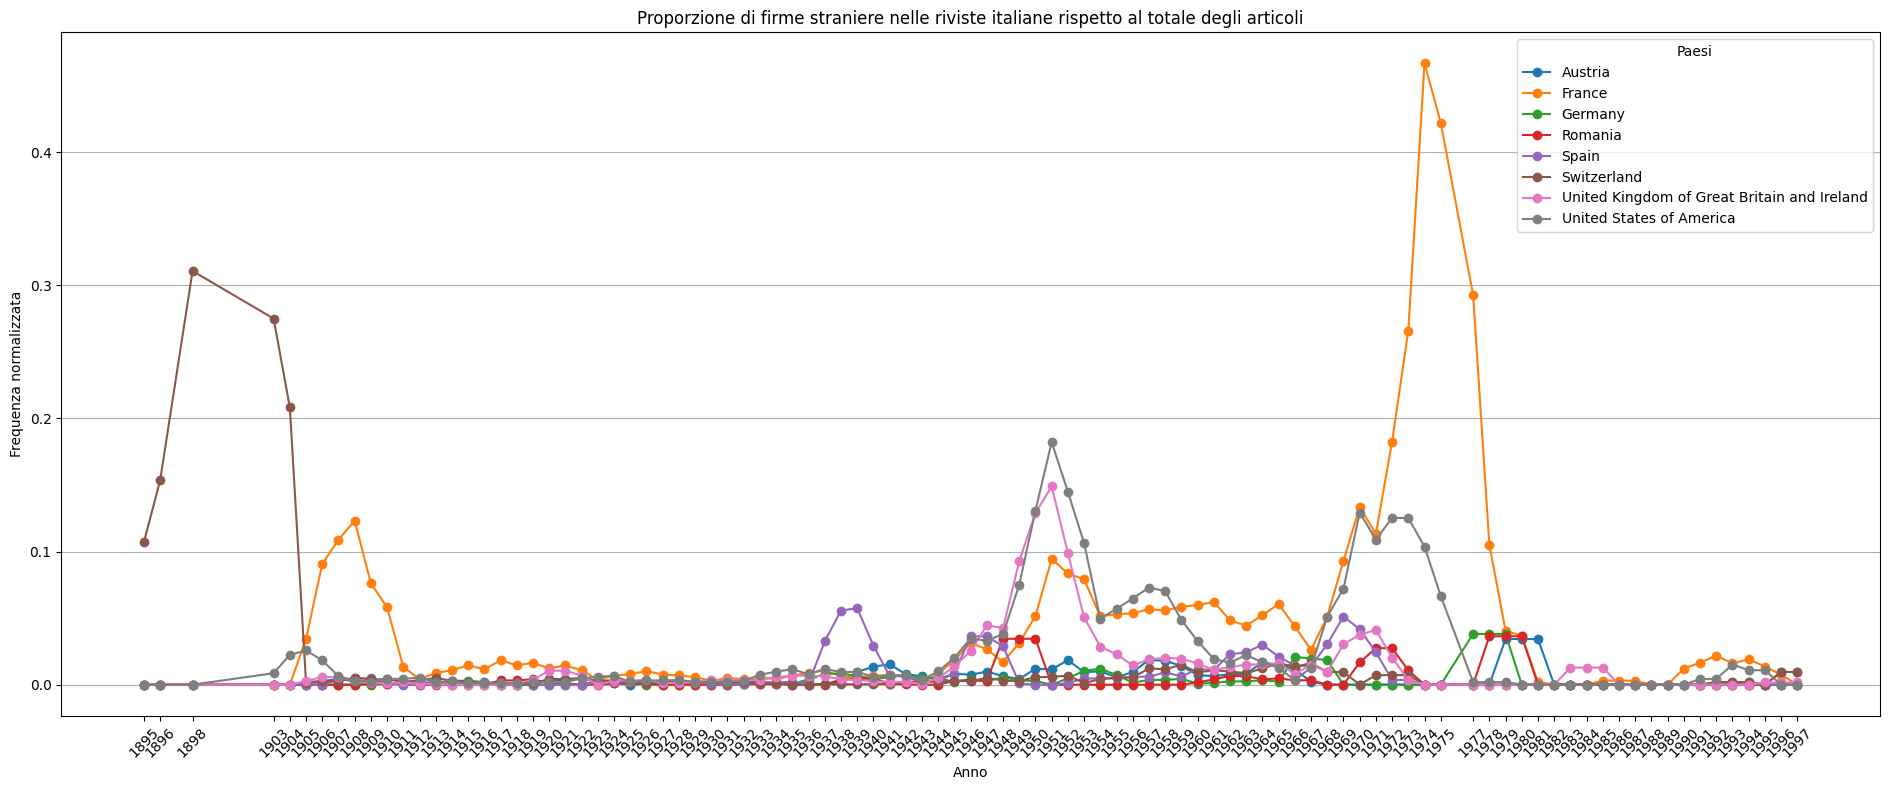

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast


file_totale_path = r'C:\Users\Mosca\Desktop\Information visualisation\file_autori_rivista_aggiornato.csv'  
df_totale = pd.read_csv(file_totale_path)

file_esteri_path = r'C:\Users\Mosca\Downloads\autori_esteri.csv'  
df_esteri = pd.read_csv(file_esteri_path)


df_esteri = df_esteri[df_esteri['Country'] != 'Italy']


df_esteri['anno'] = df_esteri['anno'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [x])
df_totale['anno'] = df_totale['anno'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [x])


all_years_totali = [year for sublist in df_totale['anno'] for year in sublist]
year_counts_totali = pd.Series(all_years_totali).value_counts().sort_index()


years_country = df_esteri.explode('anno')  
year_counts = years_country.groupby(['anno', 'Country']).size().unstack(fill_value=0)


threshold = 104  
countries_with_min_occurrences = year_counts.sum(axis=0)[year_counts.sum(axis=0) >= threshold].index
year_counts_filtered = year_counts[countries_with_min_occurrences]


year_counts_filtered = year_counts_filtered[year_counts_filtered > 0]


year_counts_filtered_normalized = year_counts_filtered.div(year_counts_totali, axis=0)


year_counts_filtered_normalized = year_counts_filtered_normalized.fillna(0)


year_counts_smoothed = year_counts_filtered_normalized.rolling(window=3, min_periods=1).mean()


year_counts_smoothed.to_csv('normalised_eu.csv')


plt.figure(figsize=(19, 8))


for country in year_counts_smoothed.columns:
    if year_counts_smoothed[country].sum() > 0:  
        plt.plot(year_counts_smoothed.index, year_counts_smoothed[country], marker='o', label=country)

plt.xlabel('Anno')
plt.ylabel('Frequenza normalizzata')
plt.title('Proporzione di firme straniere nelle riviste italiane rispetto al totale degli articoli')
plt.xticks(year_counts_smoothed.index, rotation=45)
plt.grid(axis='y')


plt.legend(title='Paesi')

plt.tight_layout()
plt.show()


### Relevant conclusions

Aside from the case of Spain in the 1930s (coinciding with Francisco Franco's dictatorship), during fascism, citations of foreign authors and the publication of their works in magazines are minimal. As is well known, post-war Italian literature becomes more outward-looking, encouraging contamination and diversification as a result of a long period of introspection within national borders.

## (Side RQ): Is fascist censorship visible in the database?

Using the previous data scraping, I used the information 'keywords' as input for a Bertopic model. The output returned a series of clusters, some of which I considered relevant to my research: words related to politics, war, or intervention. Then I traced back to the articles with that keyword and considered them in the timeline of the 20th century. Unfortunately, I do not believe the results are sufficient to demonstrate any evidence.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df_0 = pd.read_json('/Users/Mosca/Desktop/Information visualisation/autori_dati.json')
df_1 = pd.read_json('/Users/Mosca/Desktop/Information visualisation/autori_dati1.json')
df_2 = pd.read_json('/Users/Mosca/Desktop/Information visualisation/autori_dati2.json')


merged_df = pd.concat([df_0, df_1, df_2], ignore_index=True)


dati_riformattati = []


for index, row in merged_df.iterrows():
    author = row['author']
    for article in row['articles']:
        articolo_info = {
            'author': author,
            'rivista': article.get('rivista', ''),
            'anno': article.get('anno', ''),
            'titolo': article.get('titolo', ''),
            'tipologia': article.get('tipologia', ''),
            'parola chiave': article.get('parola chiave', '')
        }
        dati_riformattati.append(articolo_info)

df_riformattato = pd.DataFrame(dati_riformattati)
df_riformattato.to_csv('/Users/Mosca/Desktop/Information visualisation/articoli_completi.json')

In [ ]:

df_riformattato = pd.DataFrame(dati_riformattati)

In [ ]:

lista_chiavi = df_riformattato['parola chiave'].drop_duplicates()


lista_chiavi = lista_chiavi[~lista_chiavi.str.contains('letter|scritt|art|cinem|poe|liric|teatr', case=False, na=False)]


lista_chiavi = lista_chiavi[~lista_chiavi.str.contains(',|«', na=False)]


lista_chiavi


0                        Scuola
1                              
3                      Editoria
12             Pittura italiana
13         Biblioteche italiane
                  ...          
44866    Terminologia giuridica
44906                  Lussuria
44931              Stadio Berta
45050                Ginnastica
45112                  Acustica
Name: parola chiave, Length: 2133, dtype: object

In [ ]:
from bertopic import BERTopic


topic_model = BERTopic(min_topic_size=20, language="italian")


topics, probabilities = topic_model.fit_transform(lista_chiavi.values)


In [ ]:
topics, probabilities = topic_model.fit_transform(lista_chiavi['parola chiave'].values)


lista_chiavi['Cluster'] = topics


In [ ]:
df_riformattato =pd.read_csv('/content/file_autori_rivista_aggiornato.csv')
lista_chiavi = pd.read_csv('/content/c_filtrati.csv')

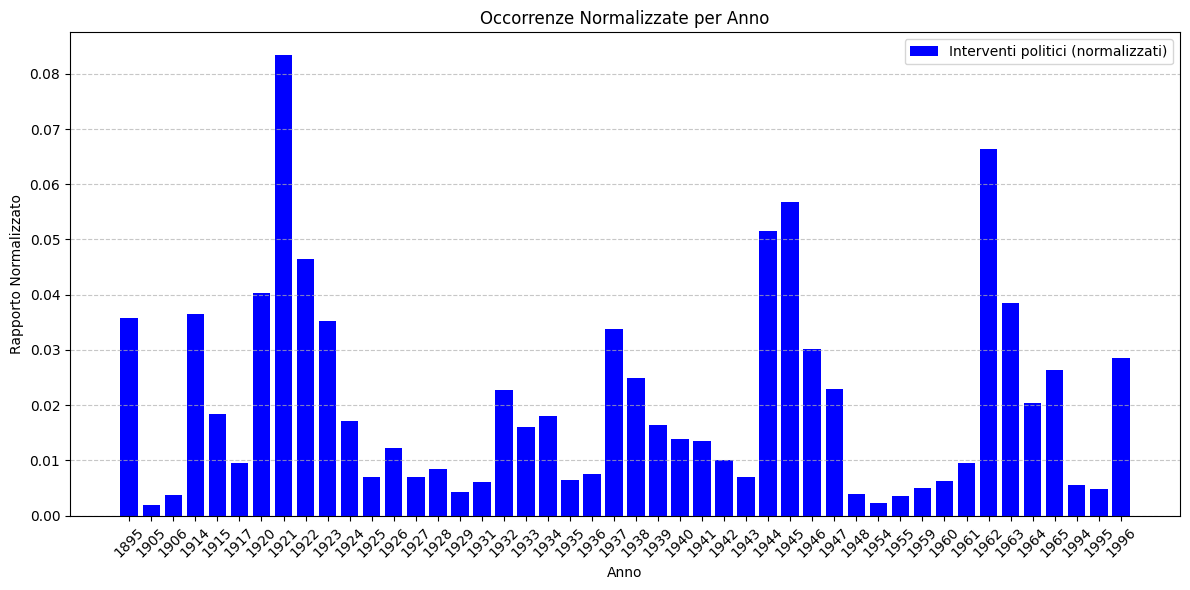

In [ ]:
file_totale_path = r'C:\Users\Mosca\Desktop\Information visualisation\file_autori_rivista_aggiornato.csv'  
df_totale = df_riformattato

total_counts = df_totale['anno'].value_counts().reset_index()
total_counts.columns = ['anno', 'totale_articoli']


matched_rows = df_riformattato[df_riformattato['parola chiave'].isin(lista_chiavi['Parola Chiave'])]

if matched_rows.empty:
    print("Nessuna corrispondenza trovata.")
else:
    
    matched_rows = matched_rows.merge(lista_chiavi[['Parola Chiave', 'Cluster']],
                                        left_on='parola chiave',
                                        right_on='Parola Chiave',
                                        how='left')

    
    year_counts = matched_rows['anno'].value_counts().reset_index()
    year_counts.columns = ['anno', 'conteggio']

    
    year_counts['anno'] = pd.to_numeric(year_counts['anno'], errors='coerce')
    year_counts = year_counts.dropna()  
    year_counts = year_counts.sort_values(by='anno')  

    
    df_year_counts = year_counts.merge(total_counts, on='anno', how='left')

    
    df_year_counts['rapporto_normalizzato'] = df_year_counts['conteggio'] / df_year_counts['totale_articoli']

    
    plt.figure(figsize=(12, 6))
    plt.bar(df_year_counts['anno'].astype(str), df_year_counts['rapporto_normalizzato'], color='blue', label='Interventi politici (normalizzati)')

    plt.title('Occorrenze Normalizzate per Anno')
    plt.xlabel('Anno')
    plt.ylabel('Rapporto Normalizzato')
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    
    plt.tight_layout()
    plt.show()

## RQ: What is the proportion between female authors and male authors?

Using the files processed earlier for extracting names, I compared them with files from the web containing Italian female and male names to infer the biological sex of the authors. I only needed to add this data to the original information to calculate the number of articles by female authors compared to those authored by men.

In [1]:
import pandas as pd
import re  


file1 = pd.read_csv(r"C:\Users\Mosca\Desktop\Information visualisation\copie dei file\autori_nomi1.csv")
file2 = pd.read_csv(r"C:\Users\Mosca\Desktop\Information visualisation\copie dei file\autori_nomi.csv")
file3 = pd.read_csv(r"C:\Users\Mosca\Desktop\Information visualisation\copie dei file\autori_nomi2.csv")


merged_df = pd.concat([file1, file2, file3]).drop_duplicates()


nomi_femminili = pd.read_csv('/Users/Mosca/Desktop/Information visualisation/nomi_femminili.csv')['Nomi'].str.strip().tolist()
nomi_maschili = pd.read_csv('/Users/Mosca/Desktop/Information visualisation/nomi_maschili.csv')['Nomi'].str.strip().tolist()


conteggio_iniziali = 0
conteggio_donne = 0
conteggio_uomini = 0

def is_initials(nome):
    
    return re.match(r'^[A-Z](\.\s*[A-Z])*\.?\s*$|^[A-Z]\s*$', nome) is not None


def classificare_sesso(nome):
    global conteggio_donne, conteggio_uomini, conteggio_iniziali  
    nomi = nome.upper().split()

    
    if any(n in nomi_maschili for n in nomi):
        conteggio_uomini += 1
        return 'M'

    
    elif any(n in nomi_femminili for n in nomi):
        conteggio_donne += 1
        return 'F'

    
    elif 'MARIA' in nomi:
        
        if not any(n in nomi_maschili for n in nomi):
            conteggio_donne += 1
            return 'F'

    
    if any(is_initials(n) for n in nomi):
        conteggio_iniziali += 1

    return 'Non specificato'  



merged_df['Sesso'] = merged_df['Nome'].apply(classificare_sesso)


merged_df.to_csv('/Users/Mosca/Desktop/autori_totali.csv', index=False)


count_non_specificato = (merged_df.iloc[:, 2] == "Non specificato").sum()

print(f"Il numero di occorrenze di 'Non specificato' nella terza colonna è: {count_non_specificato}")



print(merged_df)
print(conteggio_uomini, conteggio_donne, conteggio_iniziali)


Il numero di occorrenze di 'Non specificato' nella terza colonna è: 2912
         Cognome          Nome            Sesso
0     Abbatecola        Oronzo                M
1      Accascina         Maria                F
2      Acquaviva      Giovanni                M
3      Acquaviva         Romeo                M
4           Adam          Axel  Non specificato
...          ...           ...              ...
1193    Zošcenko       Mikhail  Non specificato
1194  Zoshchenko       Mikhail  Non specificato
1196    Zufofsky         Louis  Non specificato
1198   Zum Felde       Roberto                M
1199      Zuñiga  Eduardo Juan  Non specificato

[6695 rows x 3 columns]
3357 426 259


In [2]:

rivista_df = pd.read_csv(r'C:\Users\Mosca\Desktop\tutti_articoli.csv')


merged_df = pd.read_csv(r'/Users/Mosca/Desktop/autori_totali.csv')



merged_df['Nome_Autore_Completo'] = merged_df['Cognome'] + ', ' + merged_df['Nome']


rivista_df['Nome_Autore_Completo'] = rivista_df['author']  


df_unito = pd.merge(rivista_df, merged_df[['Nome_Autore_Completo', 'Sesso']], on='Nome_Autore_Completo', how='left')


df_unito['Sesso'].fillna('Non specificato', inplace=True)


df_unito.drop(columns=['Nome_Autore_Completo'], inplace=True)


df_unito.to_csv(r'/Users/Mosca/Desktop/Information visualisation/file_autori_rivista_aggiornato.csv', index=False)


print(df_unito)



                     author                        rivista  anno  \
0                        A.  La Fiera letteraria [I serie]  1927   
1                        A.  La Fiera letteraria [I serie]  1927   
2                        A.                        Primato  1941   
3                        A.                       Incontro  1940   
4                     A. A.  La Fiera letteraria [I serie]  1928   
...                     ...                            ...   ...   
47504  Zuñiga, Eduardo Juan            L'Europa letteraria  1964   
47505        Zupancic, Oton                        Primato  1941   
47506        Zupancic, Oton                        Primato  1941   
47507         Zweig, Stefan                         Poesia  1947   
47508         Zweig, Stefan                           '900  1928   

                                                  titolo   tipologia  \
0           Il convegno di Basilea per il film educativo  intervento   
1                                    Un

C:\Users\Mosca\AppData\Local\Temp\ipykernel_14656\4072325558.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_unito['Sesso'].fillna('Non specificato', inplace=True)


### Data exploration and visualisation

In [3]:

df = pd.read_csv(r'/Users/Mosca/Desktop/Information visualisation/file_autori_rivista_aggiornato.csv')


conteggio_per_sesso = df['Sesso'].value_counts()
numero_articoli_donne = conteggio_per_sesso.get('F', 0)
numero_articoli_uomini = conteggio_per_sesso.get('M', 0)

print(f"Numero di articoli scritti dalle donne: {numero_articoli_donne}")
print(f"Numero di articoli scritti dagli uomini: {numero_articoli_uomini}")



articoli_donne_per_anno = df[df['Sesso'] == 'F'].groupby('anno').size()


print("\nNumero di articoli scritti dalle donne per ciascun anno:")
print(articoli_donne_per_anno)


Numero di articoli scritti dalle donne: 1342
Numero di articoli scritti dagli uomini: 24034

Numero di articoli scritti dalle donne per ciascun anno:
anno
1905     8
1906    15
1907     3
1908    13
1909     6
        ..
1993    40
1994    21
1995    22
1996    10
1997     5
Length: 77, dtype: int64


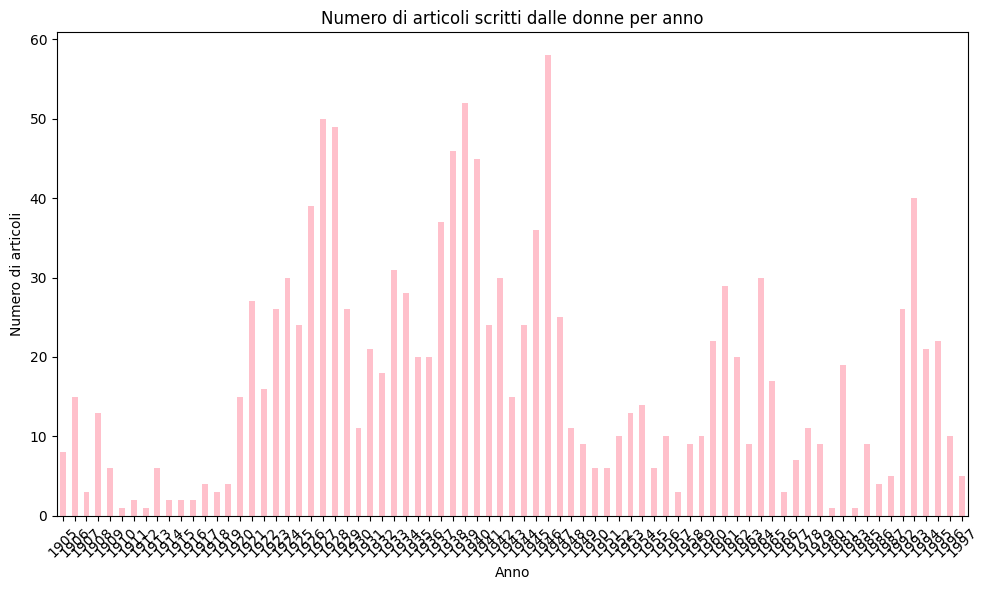

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
articoli_donne_per_anno.plot(kind='bar', color='pink')
plt.title('Numero di articoli scritti dalle donne per anno')
plt.xlabel('Anno')
plt.ylabel('Numero di articoli')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()


In [5]:
import pandas as pd


df = pd.read_csv(r'/Users/Mosca/Desktop/Information visualisation/file_autori_rivista_aggiornato.csv')


articoli_donne = df[df['Sesso'] == 'F']


conteggio_riviste = articoli_donne['rivista'].value_counts()


print("Riviste su cui hanno scritto principalmente le donne:")
print(conteggio_riviste)


Riviste su cui hanno scritto principalmente le donne:
rivista
Almanacco della donna italiana    365
Concertino                        106
L'Europa Letteraria                83
Mercurio                           67
Poesia                             47
                                 ... 
Il Contemporaneo                    1
La Riforma letteraria               1
Costume                             1
Sant'Elia                           1
Nuovi Argomenti (prima serie)       1
Name: count, Length: 66, dtype: int64


In [6]:
import pandas as pd
import numpy as np
import json


df = pd.read_csv(r'/Users/Mosca/Desktop/Information visualisation/file_autori_rivista_aggiornato.csv')


autori_donne = df[df['Sesso'] == 'F']['author'].drop_duplicates()
autori_uomini = df[df['Sesso'] == 'M']['author'].drop_duplicates()


totale_donne = autori_donne.shape[0]
totale_uomini = autori_uomini.shape[0]


articoli_donne_per_anno = df[df['Sesso'] == 'F'].groupby('anno').size()
articoli_uomini_per_anno = df[df['Sesso'] == 'M'].groupby('anno').size()


articoli_per_anno = pd.DataFrame({
    'Donne': articoli_donne_per_anno,
    'Uomini': articoli_uomini_per_anno
}).fillna(0)


articoli_per_anno['Rapporto Donne/Uomini'] = np.where(
    articoli_per_anno['Uomini'] != 0,
    articoli_per_anno['Donne'] / articoli_per_anno['Uomini'],
    np.inf
)


data = {
    'line_chart': {
        'years': articoli_per_anno.index.tolist(),
        'donne_uomini_ratio': articoli_per_anno['Rapporto Donne/Uomini'].replace(np.inf, None).tolist()  
    },
    'pie_chart': {
        'labels': ['Donne', 'Uomini'],
        'values': [totale_donne, totale_uomini]
    }
}


with open('/Users/Mosca/Desktop/Information visualisation/data_visualization.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

print("Dati salvati in data_visualization.json")


Dati salvati in data_visualization.json


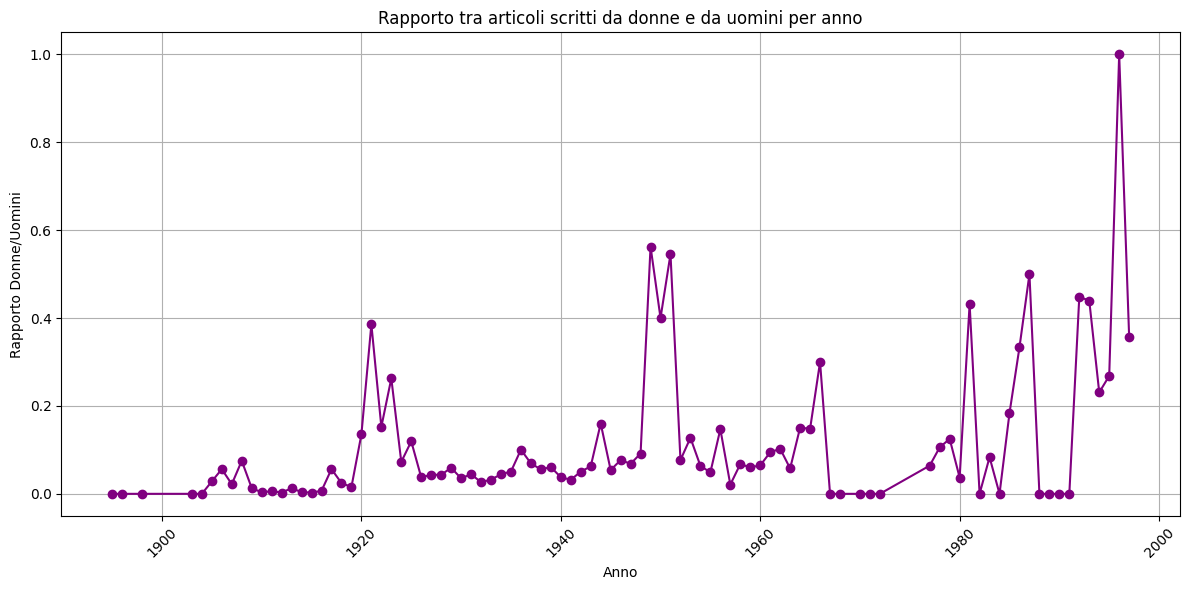

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv(r'/Users/Mosca/Desktop/Information visualisation/file_autori_rivista_aggiornato.csv')


articoli_donne_per_anno = df[df['Sesso'] == 'F'].groupby('anno').size()
articoli_uomini_per_anno = df[df['Sesso'] == 'M'].groupby('anno').size()


articoli_per_anno = pd.DataFrame({
    'Donne': articoli_donne_per_anno,
    'Uomini': articoli_uomini_per_anno
}).fillna(0)  



articoli_per_anno['Rapporto Donne/Uomini'] = np.where(
    articoli_per_anno['Uomini'] != 0,
    articoli_per_anno['Donne'] / articoli_per_anno['Uomini'],
    np.inf  
)


plt.figure(figsize=(12, 6))
plt.plot(articoli_per_anno.index, articoli_per_anno['Rapporto Donne/Uomini'], marker='o', color='purple')
plt.title('Rapporto tra articoli scritti da donne e da uomini per anno')
plt.xlabel('Anno')
plt.ylabel('Rapporto Donne/Uomini')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


plt.show()


### Relevan results

What emerges from the data is that starting from the second half of the 20th century, Italian intellectual women were increasingly involved in the cultural life of magazines. In general, however, the ratio of women to men is one to eight.

Naturally, this result has some limitations, including the impossibility of deciphering acronyms or cases where female authors write anonymously or under the generic signature of 'the editorial team.'